<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Explore-other-reward-functions" data-toc-modified-id="Explore-other-reward-functions-1">Explore other reward functions</a></span><ul class="toc-item"><li><span><a href="#Goal" data-toc-modified-id="Goal-1.1">Goal</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-1.2">Imports</a></span></li><li><span><a href="#Code" data-toc-modified-id="Code-1.3">Code</a></span><ul class="toc-item"><li><span><a href="#Data-generation" data-toc-modified-id="Data-generation-1.3.1">Data generation</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.3.2">Evaluation</a></span></li><li><span><a href="#Visualization" data-toc-modified-id="Visualization-1.3.3">Visualization</a></span></li></ul></li><li><span><a href="#Starting-the-ladder" data-toc-modified-id="Starting-the-ladder-1.4">Starting the ladder</a></span><ul class="toc-item"><li><span><a href="#Generation" data-toc-modified-id="Generation-1.4.1">Generation</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.4.2">Evaluation</a></span></li><li><span><a href="#Measuring-epsilon-agent-strength" data-toc-modified-id="Measuring-epsilon-agent-strength-1.4.3">Measuring epsilon agent strength</a></span><ul class="toc-item"><li><span><a href="#Experiments" data-toc-modified-id="Experiments-1.4.3.1">Experiments</a></span></li></ul></li></ul></li><li><span><a href="#Playing-against-greedy-agents" data-toc-modified-id="Playing-against-greedy-agents-1.5">Playing against greedy agents</a></span><ul class="toc-item"><li><span><a href="#Generation" data-toc-modified-id="Generation-1.5.1">Generation</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.5.2">Evaluation</a></span></li></ul></li><li><span><a href="#Summary" data-toc-modified-id="Summary-1.6">Summary</a></span></li></ul></li></ul></div>

# Explore other reward functions

## Goal

The goal of this notebooks is to continue learning about the Q value function, but trying other reward methods.

This is a continuation of notebook 004, which had become too big. In this notebook I will split the functionality
of playing games and generating data from training from those games.

## Imports

In [17]:
# Use this to reload changes in python scripts
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import os
import sys
import kaggle_environments
from kaggle_environments import make
from kaggle_environments import evaluate
from kaggle_environments.envs.hungry_geese.hungry_geese import Action
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import pandas as pd
from tqdm.notebook import tqdm
import time
from itertools import permutations
from functools import partial
import gc
from concurrent.futures import ProcessPoolExecutor
import json
import logging

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import tensorflow as tf
import tensorflow.keras as keras

from hungry_geese import GameState
from hungry_geese.state import make_board_egocentric, get_head_position, combine_data, horizontal_simmetry, vertical_simmetry
from hungry_geese.utils import ACTIONS, opposite_action, get_timestamp, log_ram_usage, configure_logging
from hungry_geese.definitions import ACTION_TO_IDX
from hungry_geese.agents import EpsilonAgent, QValueAgent
from hungry_geese.evaluation import play_matches_in_parallel, monitor_progress
from hungry_geese.elo import EloRanking
from hungry_geese.model import simple_model, create_model_for_training

%config Completer.use_jedi = False

In [19]:
plt.plot()
plt.close('all')
plt.rcParams["figure.figsize"] = (30, 5)  
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['font.size'] = 16

configure_logging(logging.INFO)
logger = logging.getLogger(__name__)

## Code

### Data generation

In [20]:
def play_matches_in_parallel_and_save_history(agents, max_workers=20, n_matches=1000,
                                              output_path=None,
                                              running_on_notebook=True):
    """
    Plays n_matches in parallel using ProcessPoolExecutor

    Parameters
    -----------
    agents : list
        List of the agents that we will use for playing
    """
    log_ram_usage()
    output_path = output_path or get_games_output_path(agents, n_matches)
    assert not os.path.exists(output_path), 'Output path already exists: %s' % output_path
    with ProcessPoolExecutor(max_workers=max_workers) as pool:
        matches_results = []
        submits = []
        for i in range(n_matches):
            if isinstance(agents, list):
                submits.append(pool.submit(play_game, agents=agents))
            elif callable(agents):
                submits.append(pool.submit(play_game, agents=agents()))
            else:
                raise TypeError(type(agents))
        monitor_progress(submits, running_on_notebook)
        matches_results = [submit.result() for submit in submits]
    
    log_ram_usage()
    logger.info('saving matches to json: %s' % output_path)
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    with open(output_path, 'w') as f:
        json.dump(matches_results, f)
        
    del submits
    del matches_results
    gc.collect()
    log_ram_usage()

def play_game(agents):
    env = make("hungry_geese")
    return env.run(agents=agents)

def get_games_output_path(agents, n_matches):
    output_path = '/mnt/hdd0/Kaggle/hungry_geese/games/%s_vs_%s_matches_%i.json' % (
        os.path.splitext(os.path.basename(agents[0]))[0], 
        os.path.splitext(os.path.basename(agents[1]))[0], 
        n_matches)
    return output_path

In [21]:
def test_agent(agent):
    print('Testing agent: %s' % agent)
    env = make('hungry_geese', debug=True)
    env.run([agent]*4)

In [22]:
def create_train_data_from_saved_matches(saved_games_paths, reward_name, output_path, agent_idx_range=None):
    """
    Creates train data without any simmetry
    
    Parameters
    ----------
    saved_games_paths : list of str
        Path to the games that we want to use
    reward_name : str
        Name of the reward function that we want to use
    output_path : str
        Path to the file were we are going to save the results
    max_workers : int
    agent_idx_range : list of int
        Idx of the agents we want to use for collecting data, if None all the agents
        will be used
    """
    env = make("hungry_geese")
    conf = env.configuration

    state = GameState(reward_name=reward_name)
    train_data = []
    agent_idx_range = agent_idx_range or list(range(4))
    
    for saved_games_paths in tqdm(saved_games_paths, desc='looping over saved games'):
        log_ram_usage()
        with open(saved_games_paths, 'r') as f:
            matches_results = json.load(f)
    
        for _ in tqdm(range(len(matches_results)), desc='Creating game data'):
            match = matches_results[0]
            for idx in agent_idx_range:
                state.reset()
                for step_idx, step in enumerate(match):
                    observation = step[0]['observation'].copy()
                    observation['index'] = idx
                    state.update(observation, conf)
                    if step_idx:
                        state.add_action(step[idx]['action'])
                    if not observation['geese'][idx]:
                        break
                train_data.append(state.prepare_data_for_training())
            del matches_results[0]
        
    log_ram_usage()
    train_data = combine_data(train_data)
    logger.info('Size of the boards is %.1f GB' % (train_data[0].nbytes/1e9))
    logger.info('Saving data on: %s' % output_path)
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    np.savez_compressed(output_path, boards=train_data[0], features=train_data[1], actions=train_data[2], rewards=train_data[3])
    del state
    del train_data
    gc.collect()
    log_ram_usage()

In [23]:
def create_train_data(agents, n_matches, reward_name, agent_idx_range=None):
    """
    Creates train data without any simmetry
    
    Parameters
    ----------
    agents : list of str
        Names or paths of the agents
    n_matches : int
        Number of matches to play
    reward_name : str
        Name of the reward function that we want to use
    max_workers : int
    agent_idx_range : list of int
        Idx of the agents we want to use for collecting data, if None all the agents
        will be used
    """
    saved_games_path = get_games_output_path(agents, n_matches)
    if not os.path.exists(saved_games_path):
        play_matches_in_parallel_and_save_history(agents, n_matches=n_matches)

    output_path = get_data_output_path(agents, n_matches, reward_name)
    create_train_data_from_saved_matches([saved_games_path], reward_name, output_path, agent_idx_range=agent_idx_range)
    
def get_data_output_path(agents, n_matches, reward_name):
    output_file = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_vs_%s_matches_%i.npz' % (
        reward_name,
        os.path.splitext(os.path.basename(agents[0]))[0], 
        os.path.splitext(os.path.basename(agents[1]))[0], 
        n_matches)
    return output_file

### Evaluation

In [24]:
initial_elo_ranking = pd.read_csv('../data/elo_ranking.csv', index_col='model')
initial_elo_ranking

,ranking
model,
quantum,1398
boilergoose,1269
besthoarder,1227
crazy_goose,1186
risk_averse_goose,1176
goose_on_a_healthy_diet,1157
straightforward_bfs,1004
greedy,981
greedyhoarder,766


In [25]:
agents = {
    'random': 'random',
    'random_plus': '../forum/agents/random_plus.py',
    'greedy': 'greedy',
    'risk_averse_goose': '../forum/agents/risk_averse_goose.py',
    'goose_on_a_healthy_diet': '../forum/agents/goose_on_a_healthy_diet.py',
    'straightforward_bfs': '../forum/agents/straightforward_bfs.py',
    'boilergoose': '../forum/agents/boilergoose.py',
    'crazy_goose': '../forum/agents/crazy_goose.py',
    'besthoarder': '../forum/agents/besthoarder.py',
    'greedyhoarder': '../forum/agents/greedyhoarder.py',
    'quantum': '../data/agents/quantum/quantum.py',
}

In [26]:
def evaluate_agent(new_agent, adversary_agents, n_matches, single_agent=True, max_workers=20, run_agent_test=False):
    agent_name = list(new_agent.keys())[0]
    # I have found that for certain agents if the test is run then evaluation is frozen
    if run_agent_test: test_agent(new_agent[agent_name])
    reduced_agents_set = new_agent.copy()
    for adversary_agent in adversary_agents:
        reduced_agents_set[adversary_agent] = agents[adversary_agent]
    
    if single_agent:
        sample_agents_func = lambda: [agent_name] + np.random.choice(adversary_agents, 3).tolist()
    else:
        def sample_agents_func():
            while 1:
                sampled_agents = [agent_name] + np.random.choice(adversary_agents + [agent_name], 3).tolist()
                if len(np.unique(sampled_agents)) >=2:
                    break
            return sampled_agents

    matches_agents, matches_results = play_matches_in_parallel(reduced_agents_set, sample_agents_func, n_matches=n_matches, max_workers=max_workers)
    return matches_agents, matches_results, reduced_agents_set
    
def compute_elo_ranking(matches_agents, matches_results, reduced_agents_set):
    initial_agent_elo = 1000
    for k in [32, 16, 8, 4, 2, 1]:
        agent_name = [name for name in reduced_agents_set if name not in initial_elo_ranking][0]
        initial_ranking = initial_elo_ranking.to_dict()['ranking']
        initial_ranking[agent_name] = initial_agent_elo
        initial_ranking = {key: initial_ranking[key] for key in reduced_agents_set}
        elo_ranking = EloRanking(initial_ranking, {agent_name}, k=k)
        for match_agents, match_results in zip(matches_agents, matches_results):
            elo_ranking.add_match(match_agents, match_results)
        initial_agent_elo = elo_ranking.summary().loc[agent_name, 'ranking']
    elo_ranking.plot()
    return elo_ranking.summary()

### Visualization

In [27]:
def plot_q_value(agent):
    values = np.array(agent.q_values)
    for idx, action in enumerate(ACTIONS):
        plt.plot(values[:, idx], label=action, alpha=0.6)
    plt.legend(loc=0)
    plt.grid(axis='x')

In [28]:
def save_html_games(agents, output_folder, n_games=10):
    os.makedirs(output_folder, exist_ok=True)
    env = make('hungry_geese')
    for game_idx in tqdm(range(n_games)):
        ret = env.run(agents);
        html_content = env.render(mode="html")
        filepath = os.path.join(output_folder, '%02d.html' % game_idx)
        with open(filepath, 'w') as f:
            f.write(html_content)

## Starting the ladder

### Generation

In [12]:
n_matches = 2000
agents = ['../data/agents/quantum/epsilon_quantum_025.py']*4
reward_name = 'ranking_reward_-4_4'
create_train_data(agents=agents, n_matches=n_matches, reward_name=reward_name)

2021-03-21 17:50:51,464 - hungry_geese.utils - INFO - ram_memory used: 0.36 GB	 available: 61.25 GB


  0%|          | 0/2000 [00:00<?, ?it/s]

2021-03-21 17:54:22,213 - hungry_geese.utils - INFO - ram_memory used: 1.94 GB	 available: 59.63 GB
2021-03-21 17:54:22,214 - __main__ - INFO - saving matches to json: /mnt/hdd0/Kaggle/hungry_geese/games/epsilon_quantum_025_vs_epsilon_quantum_025_matches_2000.json
2021-03-21 17:54:37,962 - hungry_geese.utils - INFO - ram_memory used: 0.36 GB	 available: 61.00 GB
2021-03-21 17:54:43,063 - hungry_geese.utils - INFO - ram_memory used: 1.46 GB	 available: 59.82 GB


Creating game data:   0%|          | 0/2000 [00:00<?, ?it/s]

2021-03-21 17:55:25,648 - hungry_geese.utils - INFO - ram_memory used: 4.24 GB	 available: 57.17 GB
2021-03-21 17:55:26,392 - __main__ - INFO - Size of the boards is 3.4 GB
2021-03-21 17:55:26,393 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-4_4/epsilon_quantum_025_vs_epsilon_quantum_025_matches_2000.npz
2021-03-21 17:55:44,807 - hungry_geese.utils - INFO - ram_memory used: 3.75 GB	 available: 57.58 GB


In [12]:
n_matches = 30000
agents = ['../data/agents/quantum/epsilon_quantum_025.py']*4
reward_name = 'ranking_reward_-4_4'
create_train_data(agents=agents, n_matches=n_matches, reward_name=reward_name)

2021-03-21 17:57:44,041 - hungry_geese.utils - INFO - ram_memory used: 0.34 GB	 available: 61.32 GB


  0%|          | 0/30000 [00:00<?, ?it/s]

2021-03-21 18:50:12,825 - hungry_geese.utils - INFO - ram_memory used: 24.25 GB	 available: 38.02 GB
2021-03-21 18:50:12,825 - __main__ - INFO - saving matches to json: /mnt/hdd0/Kaggle/hungry_geese/games/epsilon_quantum_025_vs_epsilon_quantum_025_matches_30000.json
2021-03-21 18:54:02,817 - hungry_geese.utils - INFO - ram_memory used: 0.41 GB	 available: 60.76 GB
2021-03-21 18:55:14,654 - hungry_geese.utils - INFO - ram_memory used: 16.99 GB	 available: 44.28 GB


Creating game data:   0%|          | 0/30000 [00:00<?, ?it/s]

2021-03-21 19:05:37,662 - hungry_geese.utils - INFO - ram_memory used: 58.82 GB	 available: 2.52 GB
2021-03-21 19:08:11,546 - __main__ - INFO - Size of the boards is 50.6 GB
2021-03-21 19:08:11,609 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-4_4/epsilon_quantum_025_vs_epsilon_quantum_025_matches_30000.npz
2021-03-21 19:14:18,763 - hungry_geese.utils - INFO - ram_memory used: 13.30 GB	 available: 51.30 GB


### Evaluation

  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
quantum,1398
q_value_pretrained,1366
boilergoose,1269
besthoarder,1227
crazy_goose,1186
risk_averse_goose,1176


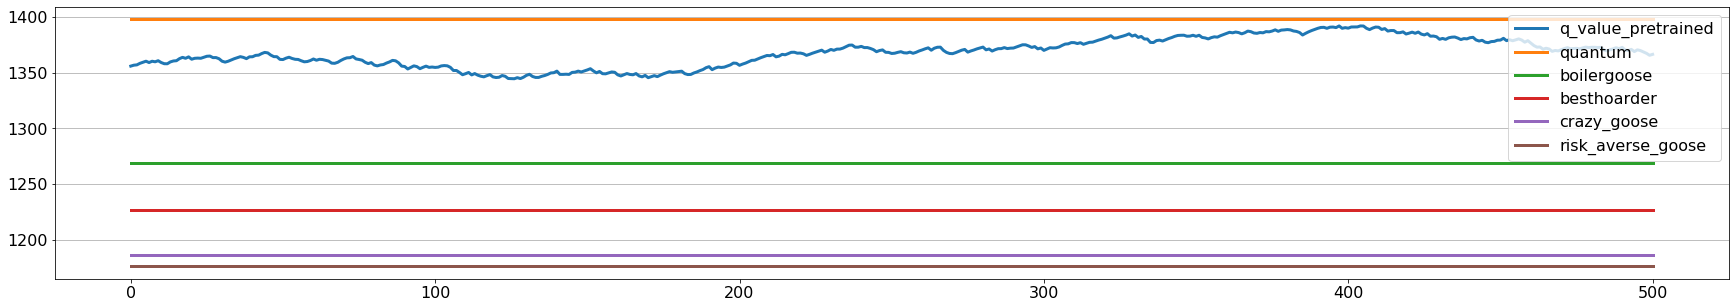

In [12]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/25_ladder_of_agents/01_epsilon025_reward_-4_4_x128_30000_pretrained/q_value_agent.py'},
    initial_elo_ranking.index.values.tolist()[:5],
    n_matches=500, single_agent=False, max_workers=20)
compute_elo_ranking(*ret)

  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
quantum,1398
q_value_pretrained,1360
boilergoose,1269
besthoarder,1227
crazy_goose,1186
risk_averse_goose,1176


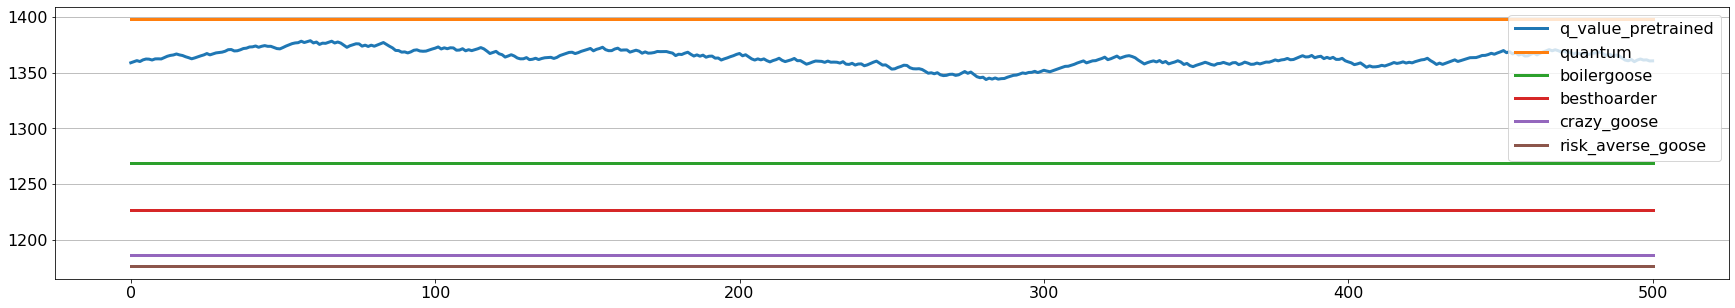

In [13]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/25_ladder_of_agents/01_epsilon025_reward_-4_4_x128_30000_pretrained/q_value_agent.py'},
    initial_elo_ranking.index.values.tolist()[:5],
    n_matches=500, single_agent=True, max_workers=20)
compute_elo_ranking(*ret)

  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
quantum,1398
q_value_pretrained,1357
boilergoose,1269
besthoarder,1227
crazy_goose,1186
risk_averse_goose,1176


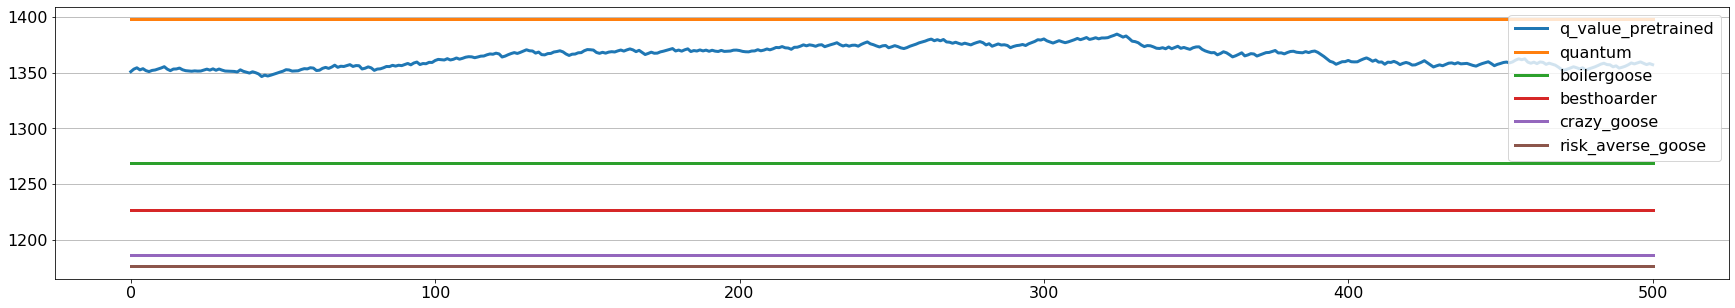

In [14]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/25_ladder_of_agents/02_epsilon025_reward_-4_4_x128_30000_from_zero/q_value_agent.py'},
    initial_elo_ranking.index.values.tolist()[:5],
    n_matches=500, single_agent=False, max_workers=20)
compute_elo_ranking(*ret)

I have the hypothesis that maybe the new agent is weak because it plays only against epsilon agents. Let's see how weak an epsilon agent is:

### Measuring epsilon agent strength

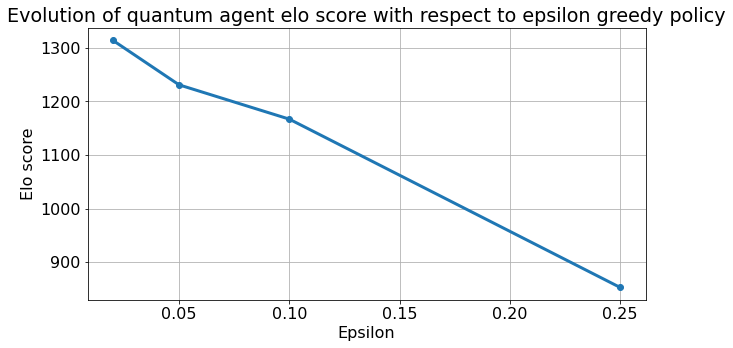

In [22]:
plt.figure(figsize=(10, 5))
epsilon = [0.25, 0.1, 0.05, 0.02]
elo = [853, 1167, 1231, 1314]
plt.plot(epsilon, elo, marker='o')
plt.grid()
plt.xlabel('Epsilon')
plt.ylabel('Elo score')
plt.title('Evolution of quantum agent elo score with respect to epsilon greedy policy');

#### Experiments

  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
quantum,1398
boilergoose,1269
besthoarder,1227
crazy_goose,1186
risk_averse_goose,1176
goose_on_a_healthy_diet,1157
straightforward_bfs,1004
greedy,981
epsilon_quantum_025,853
greedyhoarder,766


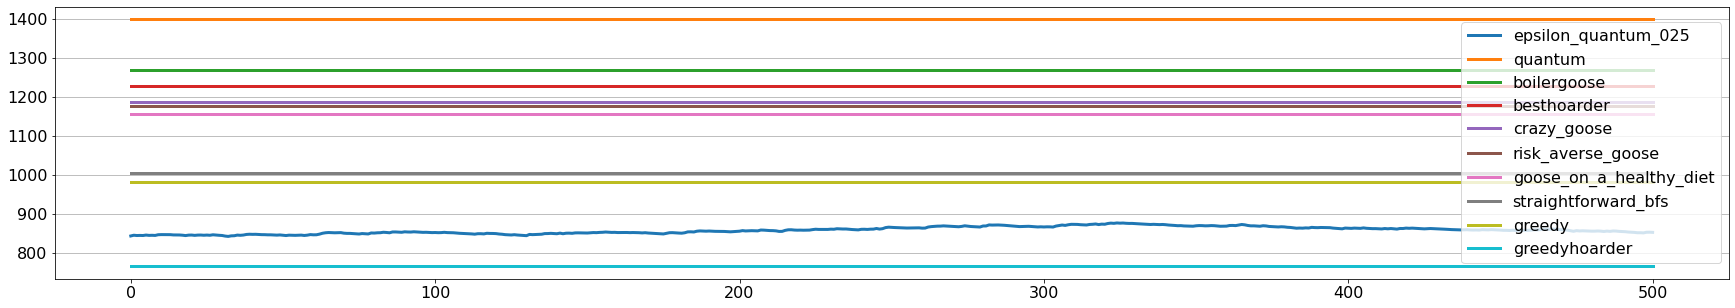

In [13]:
ret = evaluate_agent(
    {'epsilon_quantum_025': '../data/agents/quantum/epsilon_quantum_025.py'},
    initial_elo_ranking.index.values.tolist()[:-2],
    n_matches=500, single_agent=False, max_workers=20)
compute_elo_ranking(*ret)

This is very relevant. Let's try with different values of epsilon.

  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
quantum,1398
boilergoose,1269
besthoarder,1227
crazy_goose,1186
risk_averse_goose,1176
epsilon_quantum_010,1167
goose_on_a_healthy_diet,1157
straightforward_bfs,1004
greedy,981
greedyhoarder,766


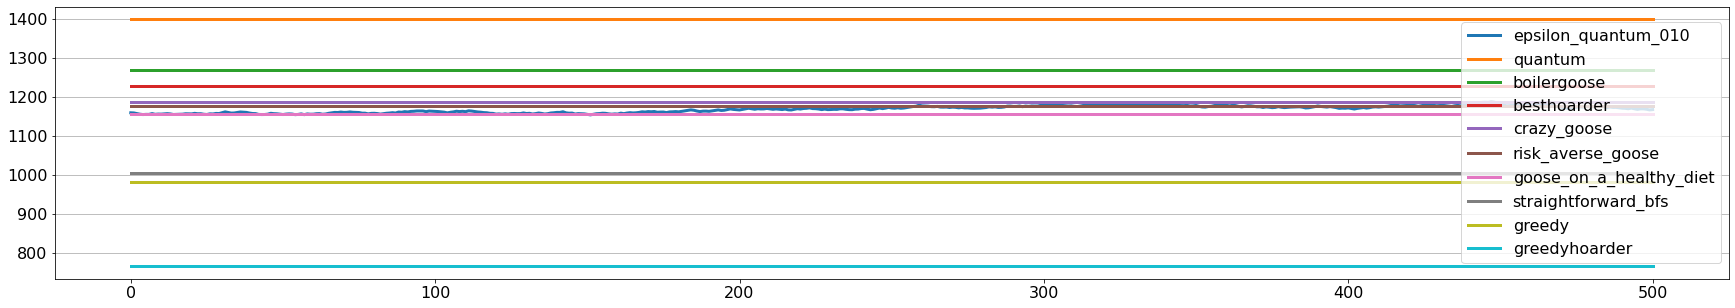

In [15]:
ret = evaluate_agent(
    {'epsilon_quantum_010': '../data/agents/quantum/epsilon_quantum_010.py'},
    initial_elo_ranking.index.values.tolist()[:-2],
    n_matches=500, single_agent=False, max_workers=20)
compute_elo_ranking(*ret)

  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
quantum,1398
boilergoose,1269
epsilon_quantum_005,1231
besthoarder,1227
crazy_goose,1186
risk_averse_goose,1176
goose_on_a_healthy_diet,1157
straightforward_bfs,1004
greedy,981
greedyhoarder,766


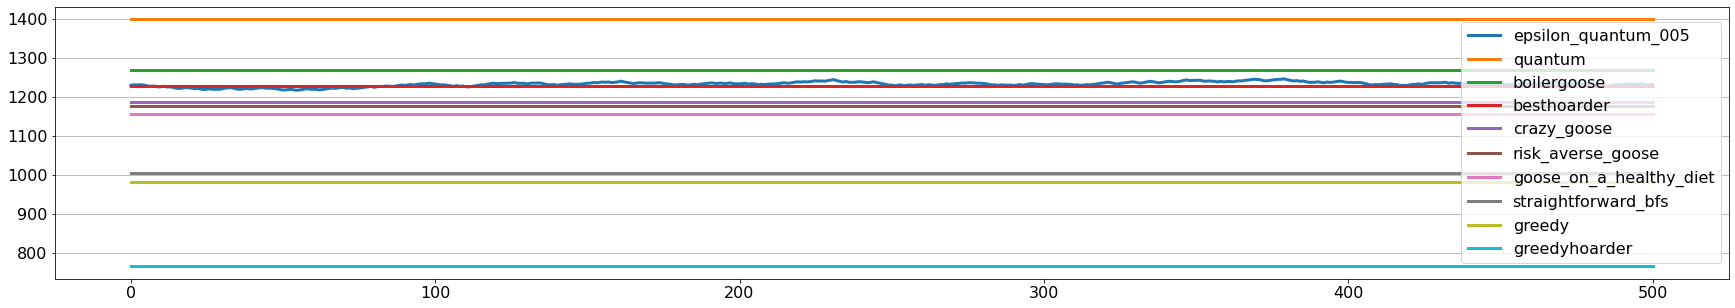

In [16]:
ret = evaluate_agent(
    {'epsilon_quantum_005': '../data/agents/quantum/epsilon_quantum_005.py'},
    initial_elo_ranking.index.values.tolist()[:-2],
    n_matches=500, single_agent=False, max_workers=20)
compute_elo_ranking(*ret)

  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
quantum,1398
epsilon_quantum_002,1314
boilergoose,1269
besthoarder,1227
crazy_goose,1186
risk_averse_goose,1176
goose_on_a_healthy_diet,1157
straightforward_bfs,1004
greedy,981
greedyhoarder,766


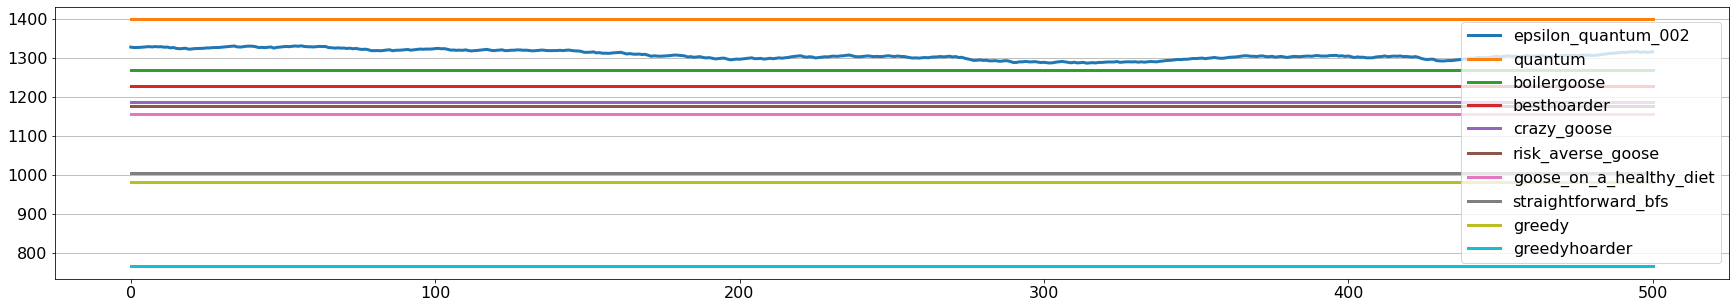

In [17]:
ret = evaluate_agent(
    {'epsilon_quantum_002': '../data/agents/quantum/epsilon_quantum_002.py'},
    initial_elo_ranking.index.values.tolist()[:-2],
    n_matches=500, single_agent=False, max_workers=20)
compute_elo_ranking(*ret)

## Playing against greedy agents

### Generation 

On a first step I have to modify the current generation functions to support giving a sampling function for the agents and also to enable using more than one json file for creating data.

In [12]:
agent_base = '../data/agents/quantum/epsilon_quantum_025.py'
best_5_agents = [agents[name] for name in initial_elo_ranking.index.values[:5]]
sampling_agent_func = lambda: [agent_base] + np.random.choice(best_5_agents, 3).tolist()
n_matches = 100

output_path = '/mnt/hdd0/Kaggle/hungry_geese/games/%s_vs_best5_matches_%i.json' % (os.path.splitext(os.path.basename(agent_base))[0], n_matches)
play_matches_in_parallel_and_save_history(agents=sampling_agent_func, n_matches=n_matches, output_path=output_path)

2021-03-22 13:10:13,066 - hungry_geese.utils - INFO - ram_memory used: 0.34 GB	 available: 61.63 GB


  0%|          | 0/100 [00:00<?, ?it/s]

2021-03-22 13:10:23,575 - hungry_geese.utils - INFO - ram_memory used: 0.46 GB	 available: 61.50 GB
2021-03-22 13:10:23,576 - __main__ - INFO - saving matches to json: /mnt/hdd0/Kaggle/hungry_geese/games/epsilon_quantum_025_vs_best5_matches_100.json
2021-03-22 13:10:24,921 - hungry_geese.utils - INFO - ram_memory used: 0.35 GB	 available: 61.61 GB


In [13]:
agent_base = '../data/agents/quantum/epsilon_quantum_010.py'
best_5_agents = [agents[name] for name in initial_elo_ranking.index.values[:5]]
sampling_agent_func = lambda: [agent_base] + np.random.choice(best_5_agents, 3).tolist()

for n_matches in [8000, 40000]:
    output_path = '/mnt/hdd0/Kaggle/hungry_geese/games/%s_vs_best5_matches_%i.json' % (os.path.splitext(os.path.basename(agent_base))[0], n_matches)
    play_matches_in_parallel_and_save_history(agents=sampling_agent_func, n_matches=n_matches, output_path=output_path)

2021-03-22 13:11:21,186 - hungry_geese.utils - INFO - ram_memory used: 0.35 GB	 available: 61.64 GB


  0%|          | 0/8000 [00:00<?, ?it/s]

2021-03-22 13:25:21,052 - hungry_geese.utils - INFO - ram_memory used: 10.44 GB	 available: 51.49 GB
2021-03-22 13:25:21,052 - __main__ - INFO - saving matches to json: /mnt/hdd0/Kaggle/hungry_geese/games/epsilon_quantum_010_vs_best5_matches_8000.json
2021-03-22 13:27:00,110 - hungry_geese.utils - INFO - ram_memory used: 0.38 GB	 available: 61.58 GB
2021-03-22 13:27:00,112 - hungry_geese.utils - INFO - ram_memory used: 0.38 GB	 available: 61.58 GB


  0%|          | 0/40000 [00:00<?, ?it/s]

2021-03-22 14:38:32,992 - hungry_geese.utils - INFO - ram_memory used: 45.88 GB	 available: 19.20 GB
2021-03-22 14:38:33,001 - __main__ - INFO - saving matches to json: /mnt/hdd0/Kaggle/hungry_geese/games/epsilon_quantum_010_vs_best5_matches_40000.json
2021-03-22 14:47:53,246 - hungry_geese.utils - INFO - ram_memory used: 0.29 GB	 available: 64.49 GB


In [29]:
agent_base = '../data/agents/quantum/epsilon_quantum_010.py'
reward_name = 'ranking_reward_-4_4'

for n_matches in [8000, 40000]:
    saved_games_path = '/mnt/hdd0/Kaggle/hungry_geese/games/%s_vs_best5_matches_%i.json' % (os.path.splitext(os.path.basename(agent_base))[0], n_matches)
    output_path = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_vs_best5_matches_%i.npz' % (reward_name, os.path.splitext(os.path.basename(agent_base))[0], n_matches)
    create_train_data_from_saved_matches([saved_games_path], reward_name, output_path, agent_idx_range=[0])

looping over saved games:   0%|          | 0/1 [00:00<?, ?it/s]

2021-03-22 15:02:53,825 - hungry_geese.utils - INFO - ram_memory used: 0.29 GB	 available: 63.71 GB


Creating game data:   0%|          | 0/8000 [00:00<?, ?it/s]

2021-03-22 15:04:44,313 - hungry_geese.utils - INFO - ram_memory used: 7.12 GB	 available: 56.82 GB
2021-03-22 15:04:45,623 - __main__ - INFO - Size of the boards is 5.4 GB
2021-03-22 15:04:45,624 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-4_4/epsilon_quantum_010_vs_best5_matches_8000.npz
2021-03-22 15:05:15,772 - hungry_geese.utils - INFO - ram_memory used: 5.73 GB	 available: 58.26 GB


looping over saved games:   0%|          | 0/1 [00:00<?, ?it/s]

2021-03-22 15:05:15,792 - hungry_geese.utils - INFO - ram_memory used: 5.73 GB	 available: 58.26 GB


Creating game data:   0%|          | 0/40000 [00:00<?, ?it/s]

2021-03-22 15:14:00,175 - hungry_geese.utils - INFO - ram_memory used: 34.43 GB	 available: 29.48 GB
2021-03-22 15:14:13,729 - __main__ - INFO - Size of the boards is 26.7 GB
2021-03-22 15:14:13,731 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-4_4/epsilon_quantum_010_vs_best5_matches_40000.npz
2021-03-22 15:16:41,399 - hungry_geese.utils - INFO - ram_memory used: 27.32 GB	 available: 36.73 GB


### Evaluation

In [ ]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/25_ladder_of_agents/03_epsilon010_vs_best5_reward_-4_4_x128_40000_pretrained/q_value_agent.py'},
    initial_elo_ranking.index.values.tolist()[:5],
    n_matches=500, single_agent=False, max_workers=20)
compute_elo_ranking(*ret)

## Summary

In [ ]:
agent_names = initial_elo_ranking.index.values.tolist()[:4]
output_folder = '../data/saved_games/02_quantum'
save_html_games([agents[name] for name in agent_names], output_folder, n_games=10)

In [ ]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/25_ladder_of_agents/01_epsilon025_reward_-4_4_x128_30000_pretrained/q_value_agent.py'},
    initial_elo_ranking.index.values.tolist()[:5],
    n_matches=500, single_agent=False, max_workers=20)
compute_elo_ranking(*ret)